In [15]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_python-4.6.0.66-cp36-abi3-win_amd64.whl (35.6 MB)


In [38]:
import os
import cv2

In [27]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
from tqdm import tqdm

In [40]:
from sklearn.preprocessing import OneHotEncoder

In [41]:
from sklearn.metrics import confusion_matrix

In [42]:
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Flatten

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))
    norm_images = []
    for image in tqdm(norm_files):
        image = cv2.imread(norm_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_images.append(image)
    norm_images = np.array(norm_images)
    return norm_images, norm_labels

In [24]:
def load_pneumonia(pneu_path):
    pneu_files = np.array(os.listdir(pneu_path))
    pneu_labels = np.array([pneu_file.split('_')[1] for pneu_file in pneu_files])
    pneu_images = []
    for image in tqdm(pneu_files):
        image = cv2.imread(pneu_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneu_images.append(image)
    pneu_images = np.array(pneu_images)
    return pneu_images, pneu_labels

In [73]:
normfile  = np.array(os.listdir('D:/Pneumonia/chest_xray/train/NORMAL/'))
normfile

array(['IM-0115-0001.jpeg', 'IM-0117-0001.jpeg', 'IM-0119-0001.jpeg', ...,
       'NORMAL2-IM-1419-0001.jpeg', 'NORMAL2-IM-1422-0001.jpeg',
       'NORMAL2-IM-1423-0001.jpeg'], dtype='<U30')

In [74]:
norm_label = np.array(['normal']*len(normfile))
norm_label

array(['normal', 'normal', 'normal', ..., 'normal', 'normal', 'normal'],
      dtype='<U6')

In [75]:
pneu_files = np.array(os.listdir('D:/Pneumonia/chest_xray/train/PNEUMONIA/'))
pneu_files 

array(['person1000_bacteria_2931.jpeg', 'person1000_virus_1681.jpeg',
       'person1001_bacteria_2932.jpeg', ..., 'person9_bacteria_39.jpeg',
       'person9_bacteria_40.jpeg', 'person9_bacteria_41.jpeg'],
      dtype='<U29')

In [76]:
pneu_label = np.array([pneu_file.split('_')[1] for pneu_file in pneu_files])
pneu_label

array(['bacteria', 'virus', 'bacteria', ..., 'bacteria', 'bacteria',
       'bacteria'], dtype='<U8')

In [25]:
pwd

'C:\\Users\\kaustubh kapare'

In [29]:
# All images are stored in _images, all labels are in _labels
norm_images, norm_labels = load_normal('D:/Pneumonia/chest_xray/train/NORMAL/')
pneu_images, pneu_labels = load_pneumonia('D:/Pneumonia/chest_xray/train/PNEUMONIA/')

100%|██████████| 3875/3875 [00:48<00:00, 79.84it/s] 


In [30]:
# Put all train images to X_train 
X_train = np.append(norm_images, pneu_images, axis=0)

In [31]:
# Put all train labels to y_train
y_train = np.append(norm_labels, pneu_labels)

In [32]:
print(X_train.shape)
print(y_train.shape)

(5216, 200, 200)
(5216,)


In [33]:
# Finding out the number of samples of each class
print(np.unique(y_train, return_counts=True))

(array(['bacteria', 'normal', 'virus'], dtype='<U8'), array([2530, 1341, 1345], dtype=int64))


Display several images


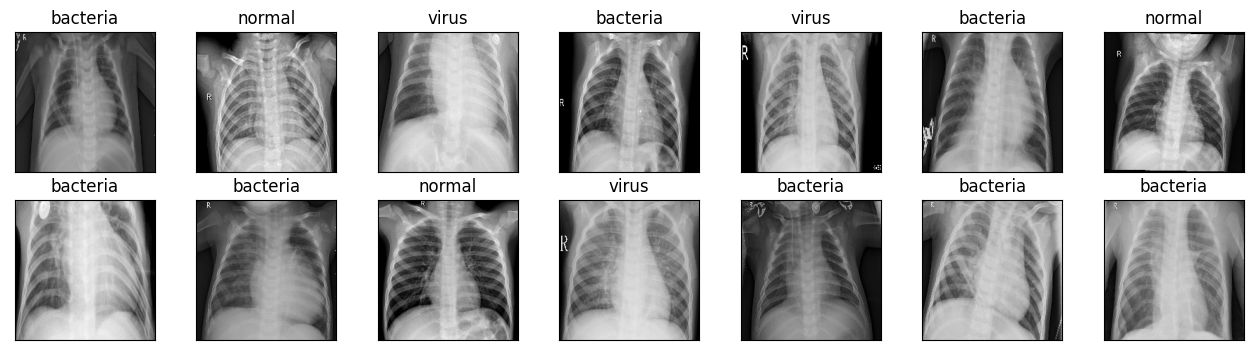

In [35]:
print('Display several images')
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))
indices = np.random.choice(len(X_train), 14)
counter = 0
for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

In [36]:
print('Loading test images')
# Do the exact same thing as what we have done on train data
norm_images_test, norm_labels_test = load_normal('D:/Pneumonia/chest_xray/test/NORMAL/')
pneu_images_test, pneu_labels_test = load_pneumonia('D:/Pneumonia/chest_xray/test/PNEUMONIA/')

Loading test images


100%|██████████| 390/390 [00:03<00:00, 105.12it/s]


In [37]:
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
y_test = np.append(norm_labels_test, pneu_labels_test)

In [ ]:
# # Save the loaded images to pickle file for future use
# with open('pneumonia_data.pickle', 'wb') as f:
#     pickle.dump((X_train, X_test, y_train, y_test), f)

# # Here's how to load it
# with open('pneumonia_data.pickle', 'rb') as f:
#     (X_train, X_test, y_train, y_test) = pickle.load(f)

In [47]:
print('Label preprocessing')
# Create new axis on all y data
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]

Label preprocessing


In [48]:
# Initialize OneHotEncoder object
one_hot_encoder = OneHotEncoder(sparse=False)

In [49]:
# Convert all labels to one-hot
y_train_one_hot = one_hot_encoder.fit_transform(y_train)
y_test_one_hot = one_hot_encoder.transform(y_test)

In [50]:
# Reshape the data into (no of samples, height, width, 1), where 1 represents a single color channel
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [51]:
# Generate new images with some randomness
datagen = ImageDataGenerator(rotation_range = 10,zoom_range = 0.1,width_shift_range = 0.1,height_shift_range = 0.1)

In [52]:
datagen.fit(X_train)
train_gen = datagen.flow(X_train,y_train_one_hot,batch_size = 32)

In [53]:
# Define the input shape of the neural network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
input_shape

(200, 200, 1)


In [57]:
input1 = Input(shape=input_shape)
cnn = Conv2D(16, (3, 3), activation='relu', strides=(1, 1),padding='same')(input1)
cnn = Conv2D(32, (3, 3), activation='relu', strides=(1, 1),padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)
cnn = Conv2D(16, (2, 2), activation='relu', strides=(1, 1),padding='same')(cnn)
cnn = Conv2D(32, (2, 2), activation='relu', strides=(1, 1),padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)
cnn = Flatten()(cnn)
cnn = Dense(100, activation='relu')(cnn)
cnn = Dense(50, activation='relu')(cnn)
output1 = Dense(3, activation='softmax')(cnn)
model = Model(inputs=input1, outputs=output1)
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['acc'])

In [58]:
# Using fit_generator() instead of fit() because we are going to use data
# taken from the generator. Note that the randomness is changing
# on each epoch
history = model.fit_generator(train_gen, epochs=30,validation_data=(X_test, y_test_one_hot))

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
163/163 [==============================] - 32s 107ms/step - loss: 6.7451 - acc: 0.5822 - val_loss: 0.8969 - val_acc: 0.6330
Epoch 2/30
163/163 [==============================] - 13s 78ms/step - loss: 0.6951 - acc: 0.7090 - val_loss: 0.6575 - val_acc: 0.7612
Epoch 3/30
163/163 [==============================] - 13s 78ms/step - loss: 0.6561 - acc: 0.7201 - val_loss: 0.7316 - val_acc: 0.7532
Epoch 4/30
163/163 [==============================] - 13s 77ms/step - loss: 0.6255 - acc: 0.7293 - val_loss: 0.8628 - val_acc: 0.6971
Epoch 5/30
163/163 [==============================] - 13s 79ms/step - loss: 0.6130 - acc: 0.7354 - val_loss: 1.1096 - val_acc: 0.6651
Epoch 6/30
163/163 [==============================] - 13s 80ms/step - loss: 0.5935 - acc: 0.7485 - val_loss: 1.1238 - val_acc: 0.6747
Epoch 7/30
163/163 [==============================] - 13s 78ms/step - loss: 0.5779 - acc: 0.7538 - val_loss: 0.9593 - val_acc: 0.7212
Epoch 8/30
163/163 [==============================] - 13s 78m

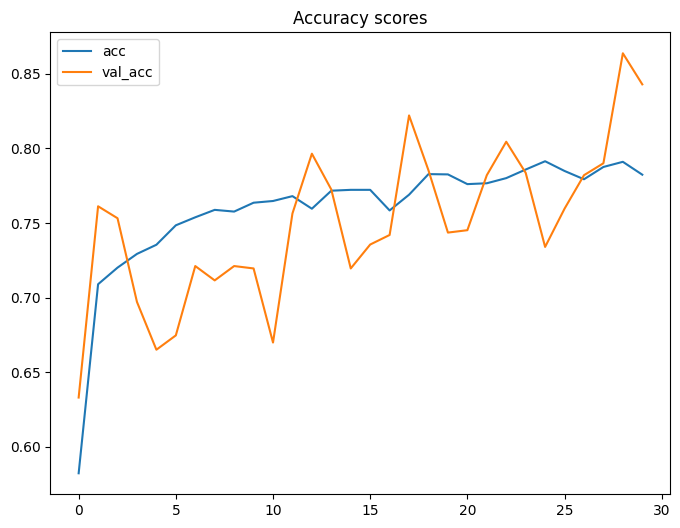

In [59]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()

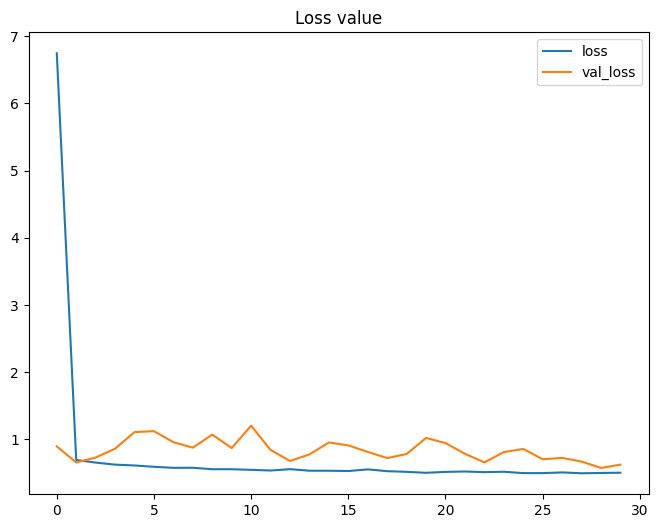

In [60]:
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [61]:
# Predicting test data
predictions = model.predict(X_test)
print(predictions)
predictions = one_hot_encoder.inverse_transform(predictions)
# print('Model evaluation')
print(one_hot_encoder.categories_)

[[0.05774405 0.9216931  0.02056289]
 [0.01805955 0.93140966 0.05053073]
 [0.6721043  0.15151572 0.17638007]
 ...
 [0.7623196  0.00303463 0.2346458 ]
 [0.7528462  0.00602637 0.24112743]
 [0.9798946  0.00342152 0.01668385]]
Model evaluation
[array(['bacteria', 'normal', 'virus'], dtype='<U8')]


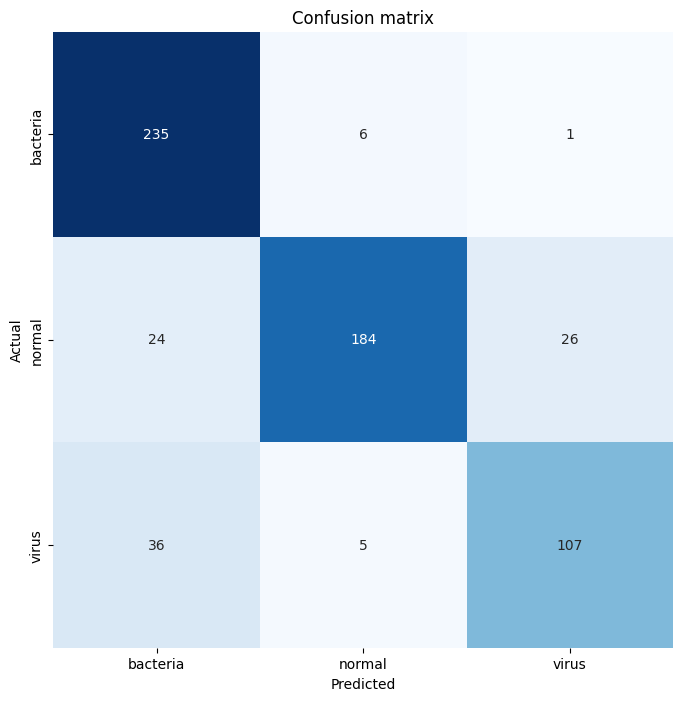

In [62]:
classnames = ['bacteria', 'normal', 'virus']
# Display confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [63]:
cm = confusion_matrix(y_test, predictions)

In [64]:
cm

array([[235,   6,   1],
       [ 24, 184,  26],
       [ 36,   5, 107]], dtype=int64)

In [65]:
from sklearn.metrics import classification_report,confusion_matrix

In [66]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

    bacteria       0.80      0.97      0.88       242
      normal       0.94      0.79      0.86       234
       virus       0.80      0.72      0.76       148

    accuracy                           0.84       624
   macro avg       0.85      0.83      0.83       624
weighted avg       0.85      0.84      0.84       624



In [67]:
# Saving model
model.save('pneumonia_cnn.h5')